
# Project 1: Digit Classification with KNN


# Intro
---
In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b> To be safe, please credit any sources used.


## Grading
---
 - Make sure to answer every part in every question.
 - There are 5 questions, each worth an equal number of points.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean or is not well commented
   - the functions or answers are excessively long

## Requirements:
---
1. Comment your code.
1. Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning, keep things inside functions).

## Additional reading and notes
---

If you are looking to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

Additionally, if you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [28]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [29]:
import sklearn
sklearn.__version__

'0.24.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [31]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X.to_numpy(), Y.to_numpy()
#X, Y = X.iloc[shuffle], Y.iloc[shuffle]
X, Y = X[shuffle], Y[shuffle]
print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

print('test_data:', test_data.shape)
print('dev_data:', dev_data.shape)
print('train_data:', train_data.shape)
print('mini_train_data:', mini_train_data.shape)

data shape:  (70000, 784)
label shape: (70000,)
test_data: (9000, 784)
dev_data: (1000, 784)
train_data: (60000, 784)
mini_train_data: (1000, 784)


['3']


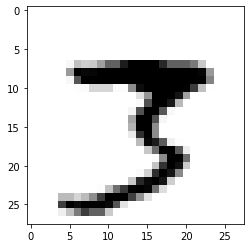

In [106]:
b = train_data[3:4]
print(train_labels[3:4])
image2 = np.array(b, dtype='float')
image2
pixels2 = image2.reshape((28, 28))
plt.imshow(pixels2, cmap=plt.cm.binary) # cmap='gray'
plt.show()

### Question 1: Visualize a select sample of images
---
Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* Make the digits nice and big.
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

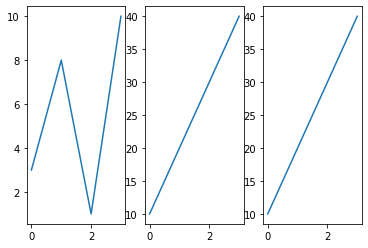

In [48]:

#plot 1:
x = np.array([0, 1, 2, 3])
y = np.array([3, 8, 1, 10])

plt.subplot(1, 3, 1)
plt.plot(x,y)

#plot 2:
x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(1, 3, 2)
plt.plot(x,y)

#plot 2:
x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30, 40])

plt.subplot(1, 3, 3)
plt.plot(x,y)


plt.show()

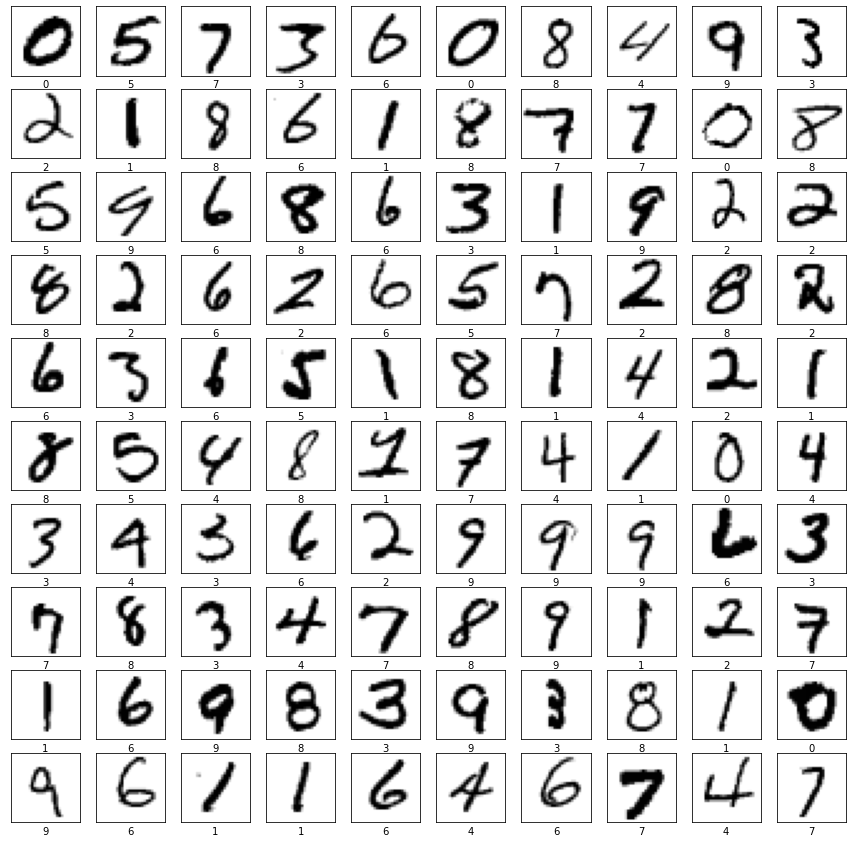

In [37]:
def Q1(num_examples=10):
  ### STUDENT START ###  
    a = num_examples  # rows
    b = num_examples  # columns
    c = 1  # plot count
    
    grid_size=num_examples*num_examples
    
    fig = plt.figure(figsize=(15,15))
    for i in range(grid_size):
        image = train_data[i:i+1]
        image = np.array(image, dtype='float')
        plt.subplot(a, b, c)
        pixels = image.reshape((28, 28))
        plt.imshow(pixels, cmap=plt.cm.binary) # cmap='gray'
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(train_labels[i])
        c+=1
        
    plt.show()
  ### STUDENT END ###

Q1(10)

### Question 2: Evaluating different choices of k
---

1. Produce k-Nearest Neighbors models with k = 1, 3, 5, 7, and 9.  
1. Print the accuracy of each model. 
1. Additionally, only for the 1-Nearest Neighbor model, show the precision, recall, and F1 for each label. 
1. Which digit is the most *difficult* for the 1-Nearest Neighbor model to classify correctly? How did you choose and why?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Print only the information asked so it is easy to read and compare.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.
* Check out what the function "score" does.

In [11]:
def Q2(k_values):

### STUDENT START ###
    for k in k_values:
        # Create KNN classifier
        knn = KNeighborsClassifier(n_neighbors = k)
        # Fit the classifier to the data
        knn.fit(mini_train_data,mini_train_labels) 

        pred = knn.predict(test_data)
        
        #check accuracy of our model on the test data
        acc = knn.score(test_data, test_labels)
        print(f"k={k}, accuracy={acc}")
        
        if(k==1):
            print(classification_report(test_labels,pred))
            
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
Q2(k_values)

k=1, accuracy=0.8784444444444445
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       862
           1       0.86      0.99      0.92      1001
           2       0.96      0.82      0.88       885
           3       0.89      0.86      0.87       949
           4       0.90      0.81      0.85       870
           5       0.84      0.84      0.84       785
           6       0.94      0.95      0.95       906
           7       0.84      0.92      0.88       939
           8       0.89      0.81      0.85       908
           9       0.77      0.82      0.79       895

    accuracy                           0.88      9000
   macro avg       0.88      0.88      0.88      9000
weighted avg       0.88      0.88      0.88      9000

k=3, accuracy=0.8726666666666667
k=5, accuracy=0.8735555555555555
k=7, accuracy=0.8663333333333333
k=9, accuracy=0.8585555555555555


Answer to part 4: F1 scores maximize both precision and recall. Precision - how accurate the model is for those predicted as positive. Recall is ability of the classifier to find all the positive samples. The F1 score takes into acount both false positves and false negative. Since 9 has .79 the lowest F1 score of all the digits then this digit is harder to classify than the other digits.

### Question 3: Examining the importance of training size
---
1. Produce 1-Nearest Neighbor models using training data of various sizes. For example, ```train_data[:train_size]```.
1. Evaluate and show the accuracy achieved by each model.  
1. Show the time needed to: 
  1. Train each model.
  1. Measure the accuracy of each model.
1. What do you see? Is this what you expected to see and why?
1. Plot on the same graph (as a function of training size):
  1. the time needed for training
  1. the time needed for calculating accuracy

Notes:
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

[0.006981372833251953, 0.0010378360748291016, 0.002990245819091797, 0.0408935546875, 0.0029921531677246094, 0.006981372833251953, 0.011967182159423828, 0.02195000648498535, 0.09342694282531738]
[0.3495345115661621, 0.49463987350463867, 0.873664379119873, 0.8746638298034668, 0.912602424621582, 1.459110975265503, 2.297853708267212, 4.647542715072632, 10.105020523071289]


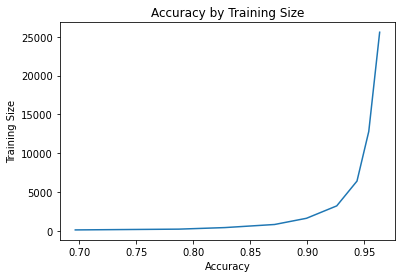

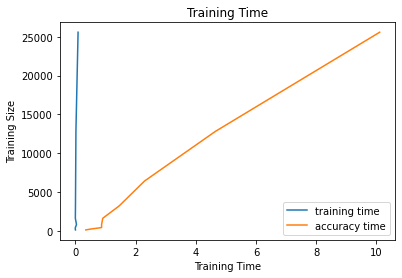

In [27]:
def Q3(train_sizes, accuracies, train_times, eval_times):

### STUDENT START ###
    for train_size in train_sizes:
        
        train_data_subset = train_data[:train_size]
        train_labels_subset = train_labels[:train_size]

        # Create KNN classifier
        knn = KNeighborsClassifier(n_neighbors = 1)
        
        # Fit the classifier to the data. Get execution time
        start = time.time()
        knn.fit(train_data_subset,train_labels_subset) 
        end = time.time()
        elapsed_time = end - start
        train_times.append(elapsed_time)
        
        pred = knn.predict(test_data)
        
        #check accuracy of our model on the test data
        start = time.time()
        acc = knn.score(test_data, test_labels)
        end = time.time()
        elapsed_time = end - start
        eval_times.append(elapsed_time)
        
        accuracies.append(acc)
        #print(f"k={k}, accuracy={acc}")

    plt.figure() # creates a figure
    plt.plot(accuracies, train_sizes)
    plt.title('Accuracy by Training Size')
    plt.xlabel('Accuracy')
    plt.ylabel('Training Size') 
    
    plt.figure() # creates a new figure
    plt.plot(train_times, train_sizes, label = "training time")
    plt.plot(eval_times, train_sizes, label = "accuracy time")
    plt.title('Training Time')
    plt.xlabel('Training Time')
    plt.ylabel('Training Size') 
    plt.legend()
    plt.show()
### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
train_times = []
eval_times = []
Q3(train_sizes, accuracies, train_times, eval_times)

### Question 4: Evaluating if we should obtain additional data
---

In this question we wish to predict what accuracy we would get if we had additional training data.

Our input, our features and labels, are the output from the previous question. Based on the training size and accuracy we got in the previous question, we wish to predict the accuracy we would get if we had larger training sizes.

1. Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. 
1. Print $R^2$ of the linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot on a lineplot graph:
  1. the actual accuracies we obtained in the previous question 
  1. and the accuracies our model predicted we would have gotten.
  1. The X axis is the training set size. 
  1. You can limit the range of X and Y to the range where you have data for both plots. Meaning, in the this question, we want to visualize how good the prediction is.
1. What are two things that are wrong with our model?
1. Apply a transformation to the predictor features and a transformation to the outcome that make the predictions fix these issues. 
1. Show $R^2$ of the improved linear regression model.  
1. Print the accuracies predicted for training set sizes 60000, 120000, and 1000000.  
1. Plot a lineplot graph of both again as before.
  1. Be sure to plot this where the Y axis is accuracy and X axis is training set size, **not the transformed space**!
  1. Choose the range of X and Y to visualize effectively.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hints:
  1. You have two problems here, how well your model fits and predicting *illogical* values of accuracy.
  1. You can look at:
    1. [logit](https://en.wikipedia.org/wiki/Logit): $\frac{1}{1 + e^{-x}} = \frac{e^x}{1+e^x}$ which takes numbers in $\[\infty,-\infty\]$ and outputs numbers in $(0, 1)$.
    1. [logistic](https://en.wikipedia.org/wiki/Logistic_function): $log(\frac{p}{1 - p})$ which takes numbers between $(0, 1)$ and outputs numbers between $\[\infty,-\infty\]$.
    1. It also happens that $x = logistic(p)$ is the same thing as $logit(x)=p$.

In [ ]:
def Q4():

### STUDENT START ###

### STUDENT END ###

Q4()

Answer to part 5:  

### Question 5: Getting to know the confusion matrix.
---

1. Produce a 1-Nearest Neighbor model.
1. Show the confusion matrix. 
1. Which digit does the model most often confuse with which digit? (*for example, the model most often mistakes the digit $1$ as the digit $7$*).
1. Show examples of the misclassified digit.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.
- No need to calculate the "most confused digits" programmatically.

In [ ]:
def Q5():

### STUDENT START ###
### STUDENT END ###

Q5()


Answer to part 3: 
